# Daily Arctic sea ice state 2017-2023

Made by Dr Adam Steer. The first iteration of this work was funded by the Norwegian Nansen Legacy Project. Later improvements and extensions are unfunded work. Please reach out if you've found this valuable and want to contribute.

Data sources:

Sea ice extent: https://nsidc.org/data/masie

Sea ice concentration: https://seaice.uni-bremen.de/databrowser/#p=sic

Sea ice drift: ftp://osisaf.met.no/archive/ice/drift_lr/merged


In [1]:

#standard library
import os
import datetime
import time
import copy

#Raster reading and handling parts
import rasterio
import xarray as xr

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.colors as colors

from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

#conc_cmap = copy.copy(plt.cm.get_cmap('Blues_r'))
#https://colorbrewer2.org/#type=sequential&scheme=Blues&n=8
conc_cmap = colors.ListedColormap(['#084594', '#4292c6', '#9ecae1', '#f7fbff'])
boundaries = [0, 0.25, 0.5, 0.75, 1]

conc_cmap.set_bad(color=[0,0,0,0])
conc_cmap.set_under(color=[0,0,0,0])


#cartopy parts
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import numpy as np
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

#CSV io and handling
import pandas as pd

#blasting out map frames:
import multiprocessing as mp


In [2]:
# this cell is left as an example of how to install any libraries missing when you run the block above. Uncomment 
# the line starting with ! and replace netcdf4 with whatever you need. The -y is important! This method of adding libraries
# won't work without it

# ! conda install netcdf4 -y

## Prepare MASIE shapefiles for plotting

In [3]:
#Linux
shpfolder = "/mnt/stuff/seaice/iceextent-shapefiles/allyears/"

#windows
#shpfolder = "../../Documents/seaice/iceextent-shapefiles/allyears/"

In [4]:
#assemble a list of geometries
plot_geoms = []
filenames = []
filedates = []

for f in os.listdir(shpfolder):
    if f.endswith('.shp'):
        thedate = f[18:25]
        year = int(thedate[0:4])
        day = int(thedate[4:])
        date = datetime.datetime(year,1,1)+datetime.timedelta(day -1)
        filedates.append(date.toordinal())
        
        #filedates.append(time.mktime(time.strptime(filedate[0:4] + '-' + filedate[4:6] + '-' + filedate[6:], "%Y-%m-%d")))
        #filedates.append(f[18:25])
        filenames.append(f)

In [5]:
filenames.sort(key=lambda x:int(x[18:25]))

In [6]:
filedates.sort()

In [7]:
filedates = np.array(filedates)

In [8]:
len(filedates)

2468

In [9]:
filenames[-1]

'masie_ice_r00_v01_2023279_4km.shp'

...so far not sure how to include this in a cartopy plot as a subplot...

## Ingest a list of ice concentrations

Daily hDF files from the university of Bremen 

In [10]:
#linux
concfolder = "/mnt/stuff/seaice/iceconc-bremen-daily/data/"

#windows
#concfolder = "../../Documents/iceconc-bremen-daily/data/"

In [11]:
#assemble a list of files, we don't ingest pixels yet
cfilenames = []
cfiledates = []

for f in os.listdir(concfolder):
    if f.endswith('.nc'):
        filedate = f[16:24]
        thedate = datetime.datetime(int(filedate[0:4]),int(filedate[4:6]),int(filedate[6:]) )
        cfiledates.append(thedate.toordinal())
        #cfiledates.append(time.mktime(time.strptime(filedate[0:4] + '-' + filedate[4:6] + '-' + filedate[6:], "%Y-%m-%d")))
        cfilenames.append(f)

In [12]:
cfilenames.sort(key=lambda x:int(x[16:24]))

In [13]:
cfiledates = np.array(cfiledates)

In [14]:
cfiledates.sort()

In [15]:
len(cfiledates)

2387

In [16]:
cfiledates

array([736330, 736331, 736332, ..., 738798, 738799, 738800])

In [17]:
concfolder + cfilenames[-1]

'/mnt/stuff/seaice/iceconc-bremen-daily/data/asi-AMSR2-n6250-20231007-v5.4.nc'

In [18]:
iceconcdata = xr.open_dataset(concfolder + cfilenames[0])


### ingest a list of ice drift datasets

In [19]:
#linux
driftfolder = "/mnt/stuff/seaice/metno-drift/alltheyears/"

#windows
#driftfolder = "../../Documents/metno-drift/alltheyears/"

In [20]:
#assemble a list of files, we don't ingest pixels yet
dfilenames = []
dfiledates = []

for f in os.listdir(driftfolder):
    if f.endswith('.nc'):
        filedate = f[35:43]
        thedate = datetime.datetime(int(filedate[0:4]),int(filedate[4:6]),int(filedate[6:]) )
        dfiledates.append(thedate.toordinal())
        dfilenames.append(f)



In [21]:
dfilenames.sort(key=lambda x:int(x[35:43]))

In [22]:
dfilenames[0:3]

['ice_drift_sh_polstere-625_multi-oi_201612301200-201701011200.nc',
 'ice_drift_sh_polstere-625_multi-oi_201612311200-201701021200.nc',
 'ice_drift_sh_polstere-625_multi-oi_201701011200-201701031200.nc']

In [23]:
len(dfilenames)

4942

In [24]:
dfilenames = dfilenames[::2]

In [25]:
len(dfilenames)

2471

In [26]:
dfilenames[0]

'ice_drift_sh_polstere-625_multi-oi_201612301200-201701011200.nc'

In [27]:
dfiledates.sort()

In [28]:
dfiledates = dfiledates[::2]

In [29]:
dfiledates = np.array(dfiledates)

In [30]:
dfiledates

array([736328, 736330, 736331, ..., 738797, 738798, 738799])

In [31]:
len(dfiledates)

2471

In [32]:
dfilenames[0:5]

['ice_drift_sh_polstere-625_multi-oi_201612301200-201701011200.nc',
 'ice_drift_sh_polstere-625_multi-oi_201701011200-201701031200.nc',
 'ice_drift_sh_polstere-625_multi-oi_201701021200-201701041200.nc',
 'ice_drift_sh_polstere-625_multi-oi_201701031200-201701051200.nc',
 'ice_drift_sh_polstere-625_multi-oi_201701041200-201701061200.nc']

In [33]:
len(dfilenames)

2471

In [34]:
### define a function to translate drift to mappable things...

def makedriftvectors(ds):

    lon = ds.lon.values
    lat = ds.lat.values
    
    fv = np.nan
    
    #get dX dY values
    dX = ds.dX.values[0]
    dY = ds.dY.values[0]
    
    ds.close()
    
    #get dataset shape
    vshape = np.shape(dX[0])
    
    #find nodata
    #zeroinds = np.where(dX == -998.)
    
    #set nodata to NaN
    #dX[zeroinds] = np.nan
    #dY[zeroinds] = np.nan
    
    # Convert vector from EASE2 grid to geographic (u east/v north)
    #coslon = np.cos(lon * np.pi/180) 
    #sinlon = np.sin(lon * np.pi/180) 

    #U_geo =  dX * coslon + dX * sinlon
    #V_geo = -dY * sinlon + dY * coslon  
    
    #rotate arrows to point in east/north polar stereographic...
    sourceproj = ccrs.PlateCarree()
    mapproj = ccrs.NorthPolarStereo()
    
    #ux,vx = mapproj.transform_vectors(sourceproj,lon,lat,U_geo,V_geo)
    ux,vx = mapproj.transform_vectors(sourceproj,lon,lat,dX,dY)

    #find 0 and replace with NaN
    
    zeroinds = np.where(ux == 0.)
    ux[zeroinds] = np.nan
    vx[zeroinds] = np.nan
    
    return(lon,lat,ux,vx)

In [35]:
icedriftdata = xr.open_dataset(driftfolder + '/' + dfilenames[366])

In [36]:
dfilenames[-1]

'ice_drift_nh_polstere-625_multi-oi_202310061200-202310081200.nc'

In [37]:
icedriftdata.dX.values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [38]:
dlon, dlat, du, dv = makedriftvectors(icedriftdata)

In [39]:
ice_speed = np.sqrt(icedriftdata.dX.values[0]**2 + icedriftdata.dY.values[0]**2)

/tmp/ipykernel_62943/388494677.py:4: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


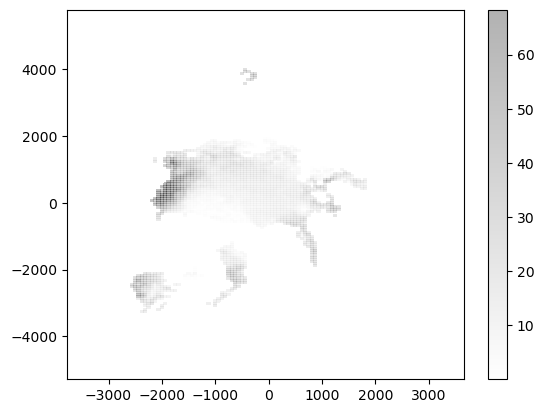

In [40]:
plt.pcolor(icedriftdata.xc.values,
                   icedriftdata.yc.values,ice_speed, cmap='gist_yarg',
                   alpha=0.3, shading='auto')
plt.colorbar()

In [41]:
icedisplacements = pd.DataFrame(columns = ['mean', 'max', 'min', 'sd'])
allthethings = []
for f in dfilenames:
    icedriftdata = xr.open_dataset(driftfolder + '/' + f)

    ice_displacement = np.sqrt(icedriftdata.dX.values[0]**2 + icedriftdata.dY.values[0]**2)
    
    allthethings.append(np.ravel(ice_displacement))


In [42]:
#allthethings = (allthethings*1000) / (24*3600)

## Collect concentrations and drifts which match extents by date

This is a key part of making sure datasets don't get out of sync

In [43]:
#set a starting date - this is the datenumber of 1 January 2017
startdate = 736330

In [44]:
#check how many ice edge files we have
len(filedates)

2468

In [45]:
#how many concentration files?
len(cfiledates)

2387

In [46]:
#how many drift files?
len(dfiledates)

2471

In [47]:
commondates = set(filedates) & set(cfiledates) & set(dfiledates)

In [48]:
commondates = list(commondates)

In [49]:
commondates.sort()

In [50]:
filenames = list(filenames)
cfilenames = list(cfilenames)
dfilenames = list(dfilenames)

In [51]:
thefiledates = []
thefilenames = []

for date in commondates:
    dateindex = np.where(filedates == date)
    thefiledates.append(filedates[dateindex])
    thefilenames.append(filenames[dateindex[0][0]])

In [52]:
thefilenames.sort(key=lambda x:int(x[18:25]))
thefiledates.sort()

In [53]:
thefilenames[-1]

'masie_ice_r00_v01_2023279_4km.shp'

In [54]:
thecfiledates = []
thecfilenames = []

for date in commondates:
    dateindex = np.where(cfiledates == date)
    thecfiledates.append(cfiledates[dateindex])
    thecfilenames.append(cfilenames[dateindex[0][0]])

In [55]:
thecfilenames.sort(key=lambda x:int(x[16:24]))
thecfiledates.sort()

In [56]:
thecfilenames[0]

'asi-AMSR2-n6250-20170101-v5.4.nc'

In [57]:
thedfiledates = []
thedfilenames = []

for date in commondates:
    dateindex = np.where(dfiledates == date)
    thedfiledates.append(dfiledates[dateindex][0])
    thedfilenames.append(dfilenames[dateindex[0][0]])

In [58]:
thefiledates = np.array(thefiledates)

In [59]:
thedfilenames.sort(key=lambda x:int(x[35:43]))
thedfiledates.sort()

In [60]:
thedfilenames[0]

'ice_drift_sh_polstere-625_multi-oi_201701011200-201701031200.nc'

## prepare a geotiff basemap for plotting
https://automating-gis-processes.github.io/CSC/notebooks/L5/plotting-raster.html

Preparing a bathymetry baselayer for Cartopy. It was produced in QGIS from IBCAOv4

In [61]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [62]:
#basemapfile = '../barents-map/maplayers-utm.tiff'
basemapfile = '/mnt/stuff/ibcaov4/rendered-bathy3.tiff'


In [63]:
#gtiff = xr.open_rasterio(basemapfile)
#gtransform = Affine.from_gdal(*gtiff.attrs['transform'])

gtiff = rasterio.rasterio.open(basemapfile)

In [64]:
gtiff.bounds

BoundingBox(left=-5171538.0, bottom=-6335436.447078747, right=5240033.0, top=4084950.4470787467)

In [65]:
im = gtiff.read()

In [66]:
red = normalize(im[0])
green = normalize(im[1])
blue = normalize(im[2])

rgb = rgb = np.dstack((red, green, blue))
del im, red, green, blue

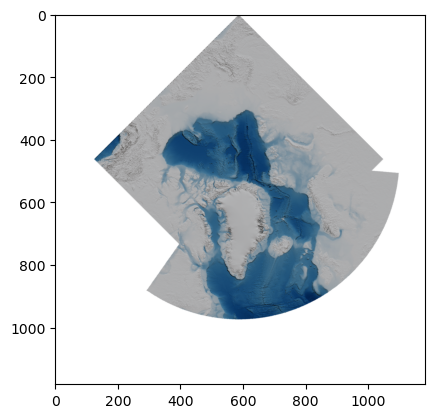

In [67]:
plt.imshow(rgb)

## Set up a land mask

...using cartopy's natural earth feature methods

In [68]:
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor=[1,1,1,0],
                                        facecolor=[0.9,0.9,0.9,1])

### assemble a list of sea ice geometries

In [69]:
thefilenames[0]

'masie_ice_r00_v01_2017001_4km.shp'

In [70]:
for f in thefilenames:
    reader = shpreader.Reader(shpfolder + '/' + f)
    plot_geoms.append(ShapelyFeature(reader.geometries(),
                        ccrs.NorthPolarStereo(central_longitude=-80, true_scale_latitude=60 )))


## Assemble a map!

Now we start making maps! Data wrangling mostly done


In [72]:
#this block kept for legacy purposes, it loads some branding for display on the final map

aenlogo = plt.imread('/mnt/stuff/seaice/branding/TheNansenLegacy-logo-EMBLEM-small.png')
nplogo = plt.imread('/mnt/stuff/seaice/branding/NPI-logo-eng-small.png')

#https://matplotlib.org/examples/pylab_examples/demo_annotation_box.html
arr_img = plt.imread("/mnt/stuff/seaice/branding/TheNansenLegacy-logo-EMBLEM.png", format='png')

In [73]:
#set up font sizes we want to use
import matplotlib.patheffects as path_effects
plt.rcParams.update({'font.size': 14,
                     'text.color': [0.6, 0.6, 0.6]})

In [74]:
#get the bounds of our bathymetric map
gtiff.bounds

BoundingBox(left=-5171538.0, bottom=-6335436.447078747, right=5240033.0, top=4084950.4470787467)

In [75]:
#set a bathymetry map extent
bathyextent = [ gtiff.bounds[0], gtiff.bounds[2], gtiff.bounds[1], gtiff.bounds[3]]

Here we use Cartopy and the Natural Earth coastlines to set up a map view. A lot of this is general Matplotlib - the important cartopy parts are in the statement adding an axis to the plot: `fig.add_sublpot(...)` contains the view CRS declaration and viewpoint details. 

`ax.set_extent` allows us to set the axis size in the CRS we choose - in this case North Polar Stereographic.

When we add new datasets to the map, we need to tell Cartopy what the data CRS is, plus any attributes *every time*. In North Polar Stereographic, make sure that you've foud the datasets central longitude and latitude of true scale - Cartopy needs to know those also.


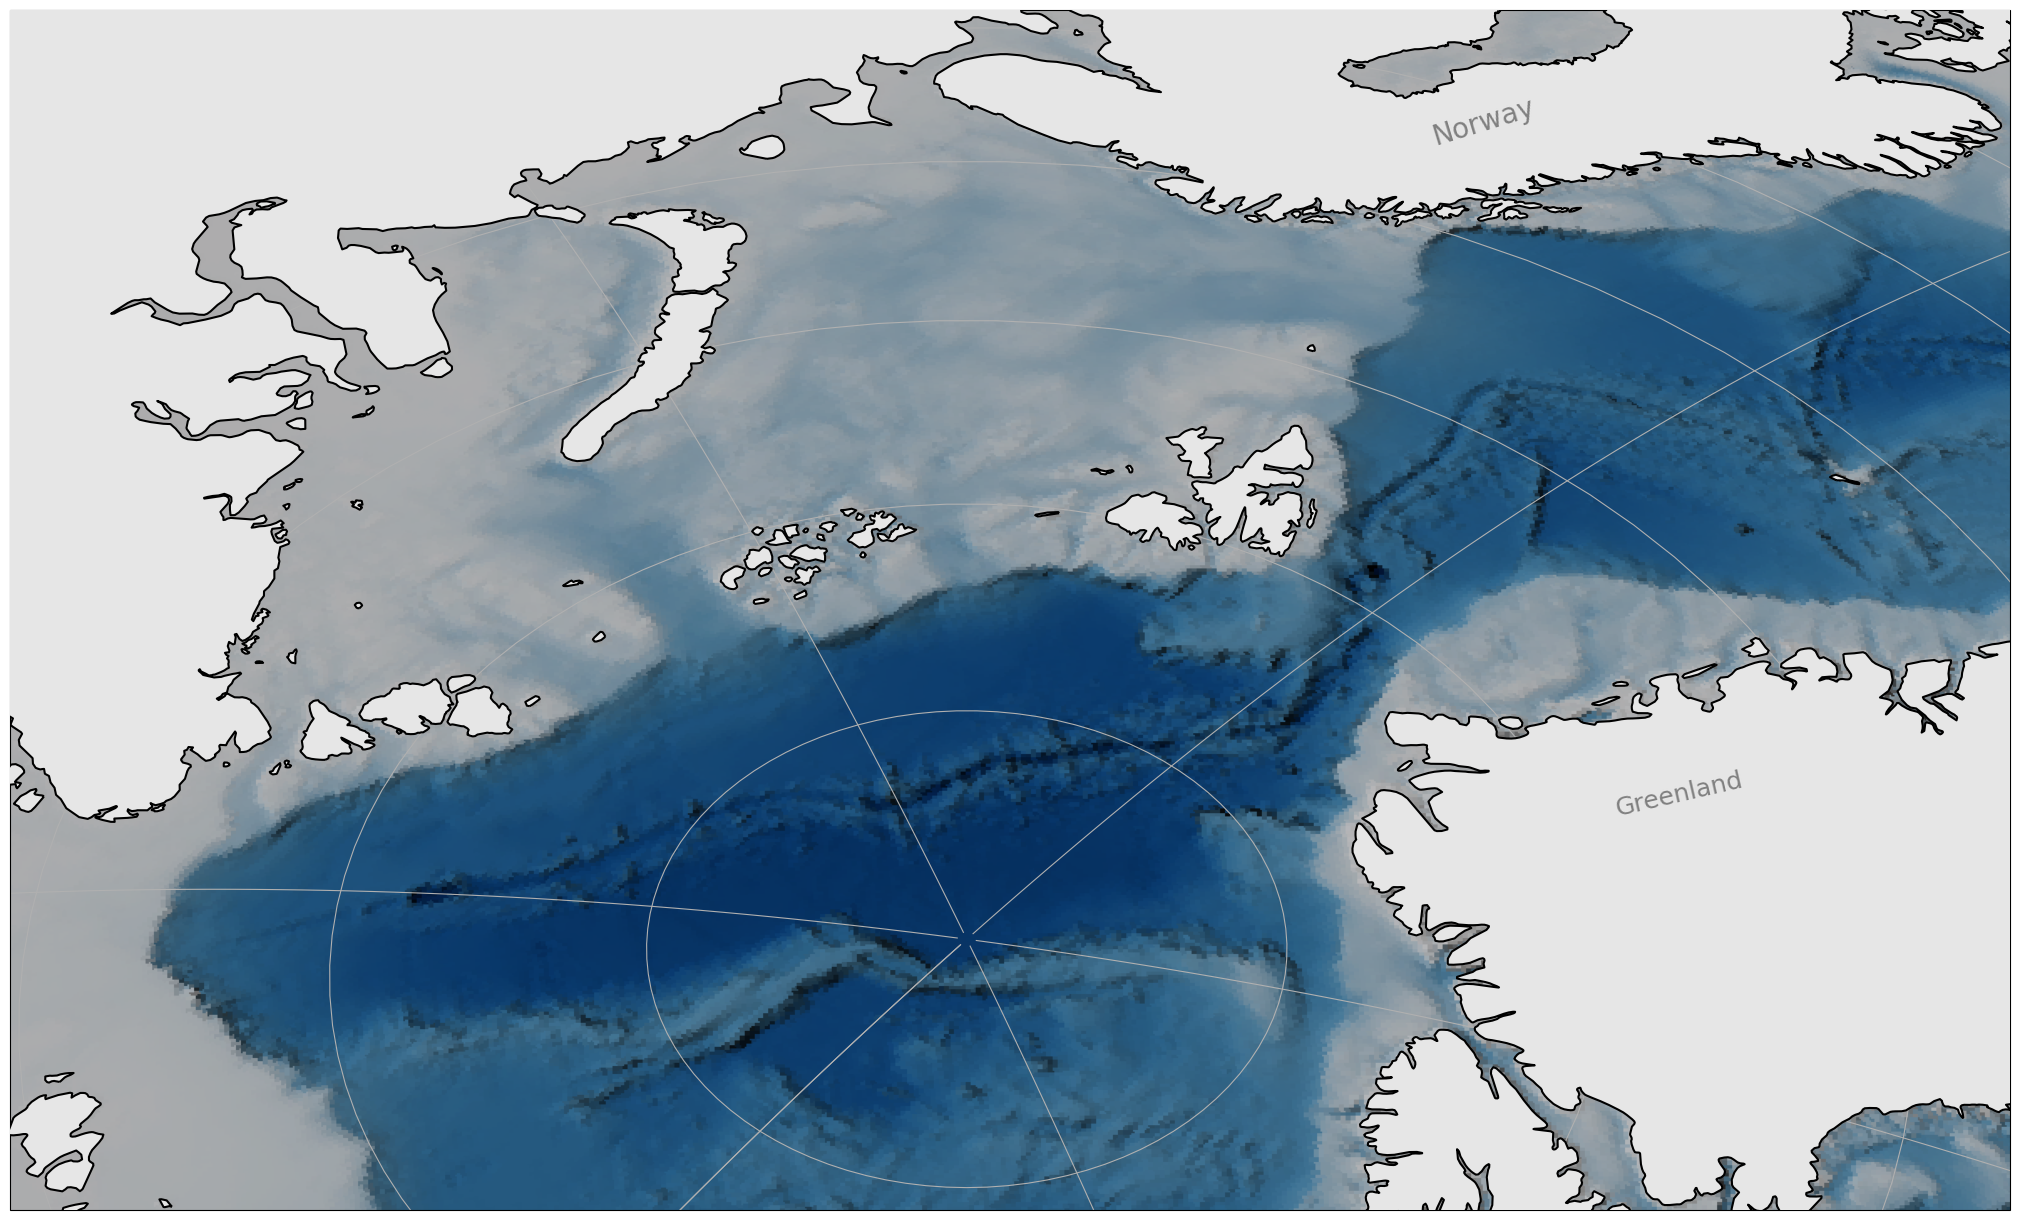

In [76]:
fig2 = plt.figure(figsize=(20,12))
ax2 = fig2.add_subplot(111, 
                     projection=ccrs.NearsidePerspective(central_longitude=-140.0, 
                                                         central_latitude=55,
                                                         false_easting=0,
                                                         satellite_height=50000000))

ax2.set_extent((-800000, 2200000, -2000000, 100000), crs=ccrs.NorthPolarStereo())

plt.gca().set_position([0, 0, 1, 1])

#adding the basemap raster
plt.imshow(rgb, origin='upper', extent= bathyextent,
           transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))

#adding land polygons
ax2.add_feature(land_50m, zorder=4999)
ax2.coastlines('50m', edgecolor=[0.8, 0.8, 0.8, 0.3], linewidth=1.5, zorder=5000)

#adding a graticule
mapgrid = ax2.gridlines(draw_labels=False, zorder=10000)
mapgrid.ypadding = 30
mapgrid.xpadding = 30

#this sets up text labels
ax2.text(-30, 78, 'Greenland', color='gray', size=18, ha='center', va='center', transform=ccrs.PlateCarree(),
         rotation=13, zorder=20000)
ax2.text(19, 66, 'Norway', color='gray', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),
         rotation=17, zorder=20001)

# this sets up logos, no longer used after my affiliation ended
#aenlogoplot = ax2.figure.figimage(aenlogo, 1750, 1080, alpha=1, zorder=50000)
#nplogoplot = ax2.figure.figimage(nplogo, 1650, 1100, alpha=1, zorder=50001)

ax2.set_aspect('auto')

## Blasting out map frames!

Once we're happy with the results of the map setup, we can apply data. This is an embarrasingly parallel problem - the part I haven't wrapped my head around yet is tracking dates between three datasets, becuase we need to be certain that a parallel worker pool is picking up the right dates for each dataset. For now, a loop will do!

In [91]:
def animate(i):

    print('making frame {}'.format(i))
    print('edge date: {}'.format(thefiledates[i]))
    print('concentration date: {}'.format(thecfiledates[i]))
    print('drift date: {}'.format(thedfiledates[i]))
    print(thefilenames[i])
    print(thedfilenames[i])
    print(thecfilenames[i])

    iceconcs = []
    iceedges = []
    icedrifts = []
    gridlines = []

    plotdate = datetime.date.fromordinal(thefiledates[i][0])
    figpngfile="/mnt/stuff/seaice/pngs/nearside"+plotdate.strftime("%d-%B-%Y")+".png"

    if not os.path.exists(figpngfile):
        print("saving: "+figpngfile)
        fig2.savefig(figpngfile)


        
        # remove any existing stuff rendered on the map
        # grids
        for conc in ax2.collections:
            conc.remove()
            del conc
        
        # vectors, except for land polygons and the grid lines
        for artist in ax2.artists[2:]:
            artist.remove()
            del artist
    
        #adding land polygons
        ax2.add_feature(land_50m, zorder=4999)
        ax2.coastlines('50m', edgecolor=[0.8, 0.8, 0.8, 0.3], linewidth=1.5, zorder=5000)
        
        #reader = shpreader.Reader(shpfolder + '/' + filenames[i])
        #edge_geom = ShapelyFeature(reader.geometries(),
        #                        ccrs.NorthPolarStereo(central_longitude=-80, true_scale_latitude=60 ))
    
        iceedge = ax2.add_feature(plot_geoms[i], edgecolor=[0.3, 0.3, 0.3], facecolor=[1,1,1,0.1], zorder=1)
    
        iceedges.append(iceedge)
    
        ## add concentration data - this is a bit arduous.. but saves on memory.
        iceconcdata = xr.open_dataset(concfolder + '/' + thecfilenames[i])
    
        xvalues = iceconcdata.x.values
        yvalues = iceconcdata.y.values
        cvalues = iceconcdata.z.values
    
        iceconcdata.close()
    
        cshape = np.shape(cvalues)
        zeroinds = np.where(cvalues == 0.)
        cvalues[zeroinds] = np.nan
        cvalues = cvalues.reshape((cshape[0], cshape[1]))
        cvalues = np.ma.masked_invalid(cvalues)
    
        #note here that we tell Cartopy what projection these data are expressed in - North Polar Stereo, 
        # *and* the expected central longitude / latitude of true scale
        iceconc = ax2.contourf(xvalues, yvalues, cvalues, cmap=conc_cmap, alpha=0.35, levels = 4,
                 transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70) )
    
        #iceconc = ax2.pcolormesh(xvalues, yvalues, cvalues, cmap=conc_cmap, alpha=0.3,shading='auto',
        #                     transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70), zorder=1)
    
    
        iceconcs.append(iceconc)
    
    
        ## add drift data
        icedriftdata = xr.open_dataset(driftfolder + '/' + thedfilenames[i])
    
        ice_displacement = np.sqrt(icedriftdata.dX.values[0]**2 + icedriftdata.dY.values[0]**2)
    
        icedrift = ax2.pcolormesh(icedriftdata.xc.values * 1000, 
                              icedriftdata.yc.values * 1000, 
                              ((ice_displacement * 1000)/(24*3600)),
                              transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
                              alpha=0.4,
                              cmap='gist_yarg',
                              shading='nearest',
                              vmin = 0, vmax = 0.5)
        
    
        icedrifts.append(icedrift)
        
        # plot and title
        showgridlines = ax2.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True,
                                      x_inline=True, y_inline=True, zorder=20000)
        ax2.xlabel_style = { "color": [0.2, 0.2, 0.2, 0.6] }
        ax2.ylabel_style = { "color": [0.2, 0.2, 0.2, 0.6] }
    
    
        #ax2.set_title('Sea ice concentration and displacement ' + plotdate.strftime("%d %B %Y"),
        #              fontsize=22, x=0.1, y=0.95, color='#222222', fontweight='bold', zorder=50000)
        
        ax2.set_title(plotdate.strftime("%d %B %Y"), 
                 fontsize=22, x = 0.3, y=0.05, color='black',fontweight='bold', zorder=50000)
    
        #ax2.figure.figimage(aenlogo, 20, 140, alpha=1)
    
    else:
        print("file exists, moving on")
    
    return tuple(iceedges)+tuple(iceconcs)+tuple(icedrifts)

#write with contourf
anim = animation.FuncAnimation(fig2, animate, frames = len(thedfilenames), interval = 100, blit=False)

#write with pcolormesh
#anim = animation.FuncAnimation(fig2, animate, frames = len(plot_geoms), interval = 200, blit=False)
plt.show()

In [92]:
#set up a movie filename
f = '/mnt/stuff/seaice/seaice-daily-velocity-more-arctic-ms-nearside3.mp4'

In [93]:
writemp4 = animation.FFMpegWriter(fps=12)

## ...and Action!

Press go! Running the next cell will take a while - it is writing out thousands of PNG files **and** making a movie.

If you're reading this notebook on gitlab, excuse the reams of output spew at the minute. All the important stuff is done, anything below is experimental and probably doesn't work.

In [94]:
anim.save(f, writer=writemp4, dpi=300)

making frame 0
edge date: [736330]
concentration date: [736330]
drift date: 736330
masie_ice_r00_v01_2017001_4km.shp
ice_drift_sh_polstere-625_multi-oi_201701011200-201701031200.nc
asi-AMSR2-n6250-20170101-v5.4.nc
file exists, moving on
making frame 0
edge date: [736330]
concentration date: [736330]
drift date: 736330
masie_ice_r00_v01_2017001_4km.shp
ice_drift_sh_polstere-625_multi-oi_201701011200-201701031200.nc
asi-AMSR2-n6250-20170101-v5.4.nc
file exists, moving on
making frame 1
edge date: [736331]
concentration date: [736331]
drift date: 736331
masie_ice_r00_v01_2017002_4km.shp
ice_drift_sh_polstere-625_multi-oi_201701021200-201701041200.nc
asi-AMSR2-n6250-20170102-v5.4.nc
file exists, moving on
making frame 2
edge date: [736332]
concentration date: [736332]
drift date: 736332
masie_ice_r00_v01_2017003_4km.shp
ice_drift_sh_polstere-625_multi-oi_201701031200-201701051200.nc
asi-AMSR2-n6250-20170103-v5.4.nc
file exists, moving on
making frame 3
edge date: [736333]
concentration dat

making frame 517
edge date: [736849]
concentration date: [736849]
drift date: [736849 736849]
ice_drift_nh_polstere-625_multi-oi_201806041200-201806061200.nc
asi-AMSR2-n6250-20180604-v5.4.nc
making frame 518
edge date: [736850]
concentration date: [736850]
drift date: [736850 736850]
ice_drift_sh_polstere-625_multi-oi_201806051200-201806071200.nc
asi-AMSR2-n6250-20180605-v5.4.nc
making frame 519
edge date: [736851]
concentration date: [736851]
drift date: [736851 736851]
ice_drift_nh_polstere-625_multi-oi_201806061200-201806081200.nc
asi-AMSR2-n6250-20180606-v5.4.nc
making frame 520
edge date: [736852]
concentration date: [736852]
drift date: [736852 736852]
ice_drift_sh_polstere-625_multi-oi_201806071200-201806091200.nc
asi-AMSR2-n6250-20180607-v5.4.nc
making frame 521
edge date: [736853]
concentration date: [736853]
drift date: [736853 736853]
ice_drift_sh_polstere-625_multi-oi_201806081200-201806101200.nc
asi-AMSR2-n6250-20180608-v5.4.nc
making frame 522
edge date: [736854]
concentr

making frame 560
edge date: [736892]
concentration date: [736892]
drift date: [736892 736892]
ice_drift_nh_polstere-625_multi-oi_201807171200-201807191200.nc
asi-AMSR2-n6250-20180717-v5.4.nc
making frame 561
edge date: [736893]
concentration date: [736893]
drift date: [736893 736893]
ice_drift_sh_polstere-625_multi-oi_201807181200-201807201200.nc
asi-AMSR2-n6250-20180718-v5.4.nc
making frame 562
edge date: [736894]
concentration date: [736894]
drift date: [736894 736894]
ice_drift_nh_polstere-625_multi-oi_201807191200-201807211200.nc
asi-AMSR2-n6250-20180719-v5.4.nc
making frame 563
edge date: [736895]
concentration date: [736895]
drift date: [736895 736895]
ice_drift_sh_polstere-625_multi-oi_201807201200-201807221200.nc
asi-AMSR2-n6250-20180720-v5.4.nc
making frame 564
edge date: [736896]
concentration date: [736896]
drift date: [736896 736896]
ice_drift_nh_polstere-625_multi-oi_201807211200-201807231200.nc
asi-AMSR2-n6250-20180721-v5.4.nc
making frame 565
edge date: [736897]
concentr

making frame 603
edge date: [736935]
concentration date: [736935]
drift date: [736935 736935]
ice_drift_sh_polstere-625_multi-oi_201808291200-201808311200.nc
asi-AMSR2-n6250-20180829-v5.4.nc
making frame 604
edge date: [736936]
concentration date: [736936]
drift date: [736936 736936]
ice_drift_sh_polstere-625_multi-oi_201808301200-201809011200.nc
asi-AMSR2-n6250-20180830-v5.4.nc
making frame 605
edge date: [736937]
concentration date: [736937]
drift date: [736937 736937]
ice_drift_sh_polstere-625_multi-oi_201808311200-201809021200.nc
asi-AMSR2-n6250-20180831-v5.4.nc
making frame 606
edge date: [736938]
concentration date: [736938]
drift date: [736938 736938]
ice_drift_nh_polstere-625_multi-oi_201809011200-201809031200.nc
asi-AMSR2-n6250-20180901-v5.4.nc
making frame 607
edge date: [736939]
concentration date: [736939]
drift date: [736939 736939]
ice_drift_sh_polstere-625_multi-oi_201809021200-201809041200.nc
asi-AMSR2-n6250-20180902-v5.4.nc
making frame 608
edge date: [736940]
concentr

making frame 646
edge date: [736978]
concentration date: [736978]
drift date: [736978 736978]
ice_drift_nh_polstere-625_multi-oi_201810111200-201810131200.nc
asi-AMSR2-n6250-20181011-v5.4.nc
making frame 647
edge date: [736979]
concentration date: [736979]
drift date: [736979 736979]
ice_drift_nh_polstere-625_multi-oi_201810121200-201810141200.nc
asi-AMSR2-n6250-20181012-v5.4.nc
making frame 648
edge date: [736980]
concentration date: [736980]
drift date: [736980 736980]
ice_drift_sh_polstere-625_multi-oi_201810131200-201810151200.nc
asi-AMSR2-n6250-20181013-v5.4.nc
making frame 649
edge date: [736981]
concentration date: [736981]
drift date: [736981 736981]
ice_drift_sh_polstere-625_multi-oi_201810141200-201810161200.nc
asi-AMSR2-n6250-20181014-v5.4.nc
making frame 650
edge date: [736982]
concentration date: [736982]
drift date: [736982 736982]
ice_drift_sh_polstere-625_multi-oi_201810151200-201810171200.nc
asi-AMSR2-n6250-20181015-v5.4.nc
making frame 651
edge date: [736983]
concentr

making frame 689
edge date: [737021]
concentration date: [737021]
drift date: [737021 737021]
ice_drift_sh_polstere-625_multi-oi_201811231200-201811251200.nc
asi-AMSR2-n6250-20181123-v5.4.nc
making frame 690
edge date: [737022]
concentration date: [737022]
drift date: [737022 737022]
ice_drift_nh_polstere-625_multi-oi_201811241200-201811261200.nc
asi-AMSR2-n6250-20181124-v5.4.nc
making frame 691
edge date: [737023]
concentration date: [737023]
drift date: [737023 737023]
ice_drift_nh_polstere-625_multi-oi_201811251200-201811271200.nc
asi-AMSR2-n6250-20181125-v5.4.nc
making frame 692
edge date: [737024]
concentration date: [737024]
drift date: [737024 737024]
ice_drift_nh_polstere-625_multi-oi_201811261200-201811281200.nc
asi-AMSR2-n6250-20181126-v5.4.nc
making frame 693
edge date: [737025]
concentration date: [737025]
drift date: [737025 737025]
ice_drift_nh_polstere-625_multi-oi_201811271200-201811291200.nc
asi-AMSR2-n6250-20181127-v5.4.nc
making frame 694
edge date: [737026]
concentr

making frame 732
edge date: [737064]
concentration date: [737064]
drift date: [737064 737064]
ice_drift_nh_polstere-625_multi-oi_201901051200-201901071200.nc
asi-AMSR2-n6250-20190105-v5.4.nc
making frame 733
edge date: [737065]
concentration date: [737065]
drift date: [737065 737065]
ice_drift_sh_polstere-625_multi-oi_201901061200-201901081200.nc
asi-AMSR2-n6250-20190106-v5.4.nc
making frame 734
edge date: [737066]
concentration date: [737066]
drift date: [737066 737066]
ice_drift_sh_polstere-625_multi-oi_201901071200-201901091200.nc
asi-AMSR2-n6250-20190107-v5.4.nc
making frame 735
edge date: [737067]
concentration date: [737067]
drift date: [737067 737067]
ice_drift_nh_polstere-625_multi-oi_201901081200-201901101200.nc
asi-AMSR2-n6250-20190108-v5.4.nc
making frame 736
edge date: [737068]
concentration date: [737068]
drift date: [737068 737068]
ice_drift_nh_polstere-625_multi-oi_201901091200-201901111200.nc
asi-AMSR2-n6250-20190109-v5.4.nc
making frame 737
edge date: [737069]
concentr

making frame 775
edge date: [737107]
concentration date: [737107]
drift date: [737107 737107]
ice_drift_nh_polstere-625_multi-oi_201902171200-201902191200.nc
asi-AMSR2-n6250-20190217-v5.4.nc
making frame 776
edge date: [737108]
concentration date: [737108]
drift date: [737108 737108]
ice_drift_nh_polstere-625_multi-oi_201902181200-201902201200.nc
asi-AMSR2-n6250-20190218-v5.4.nc
making frame 777
edge date: [737109]
concentration date: [737109]
drift date: [737109 737109]
ice_drift_nh_polstere-625_multi-oi_201902191200-201902211200.nc
asi-AMSR2-n6250-20190219-v5.4.nc
making frame 778
edge date: [737110]
concentration date: [737110]
drift date: [737110 737110]
ice_drift_sh_polstere-625_multi-oi_201902201200-201902221200.nc
asi-AMSR2-n6250-20190220-v5.4.nc
making frame 779
edge date: [737111]
concentration date: [737111]
drift date: [737111 737111]
ice_drift_sh_polstere-625_multi-oi_201902211200-201902231200.nc
asi-AMSR2-n6250-20190221-v5.4.nc
making frame 780
edge date: [737112]
concentr

making frame 818
edge date: [737150]
concentration date: [737150]
drift date: [737150 737150]
ice_drift_nh_polstere-625_multi-oi_201904011200-201904031200.nc
asi-AMSR2-n6250-20190401-v5.4.nc
making frame 819
edge date: [737151]
concentration date: [737151]
drift date: [737151 737151]
ice_drift_nh_polstere-625_multi-oi_201904021200-201904041200.nc
asi-AMSR2-n6250-20190402-v5.4.nc
making frame 820
edge date: [737152]
concentration date: [737152]
drift date: [737152 737152]
ice_drift_nh_polstere-625_multi-oi_201904031200-201904051200.nc
asi-AMSR2-n6250-20190403-v5.4.nc
making frame 821
edge date: [737153]
concentration date: [737153]
drift date: [737153 737153]
ice_drift_nh_polstere-625_multi-oi_201904041200-201904061200.nc
asi-AMSR2-n6250-20190404-v5.4.nc
making frame 822
edge date: [737154]
concentration date: [737154]
drift date: [737154 737154]
ice_drift_sh_polstere-625_multi-oi_201904051200-201904071200.nc
asi-AMSR2-n6250-20190405-v5.4.nc
making frame 823
edge date: [737155]
concentr

making frame 861
edge date: [737196]
concentration date: [737196]
drift date: [737196 737196]
ice_drift_nh_polstere-625_multi-oi_201905171200-201905191200.nc
asi-AMSR2-n6250-20190517-v5.4.nc
making frame 862
edge date: [737197]
concentration date: [737197]
drift date: [737197 737197]
ice_drift_sh_polstere-625_multi-oi_201905181200-201905201200.nc
asi-AMSR2-n6250-20190518-v5.4.nc
making frame 863
edge date: [737198]
concentration date: [737198]
drift date: [737198 737198]
ice_drift_sh_polstere-625_multi-oi_201905191200-201905211200.nc
asi-AMSR2-n6250-20190519-v5.4.nc
making frame 864
edge date: [737199]
concentration date: [737199]
drift date: [737199 737199]
ice_drift_nh_polstere-625_multi-oi_201905201200-201905221200.nc
asi-AMSR2-n6250-20190520-v5.4.nc
making frame 865
edge date: [737200]
concentration date: [737200]
drift date: [737200 737200]
ice_drift_sh_polstere-625_multi-oi_201905211200-201905231200.nc
asi-AMSR2-n6250-20190521-v5.4.nc
making frame 866
edge date: [737201]
concentr

making frame 904
edge date: [737239]
concentration date: [737239]
drift date: [737239 737239]
ice_drift_nh_polstere-625_multi-oi_201906291200-201907011200.nc
asi-AMSR2-n6250-20190629-v5.4.nc
making frame 905
edge date: [737240]
concentration date: [737240]
drift date: [737240 737240]
ice_drift_sh_polstere-625_multi-oi_201906301200-201907021200.nc
asi-AMSR2-n6250-20190630-v5.4.nc
making frame 906
edge date: [737241]
concentration date: [737241]
drift date: [737241 737241]
ice_drift_sh_polstere-625_multi-oi_201907011200-201907031200.nc
asi-AMSR2-n6250-20190701-v5.4.nc
making frame 907
edge date: [737242]
concentration date: [737242]
drift date: [737242 737242]
ice_drift_nh_polstere-625_multi-oi_201907021200-201907041200.nc
asi-AMSR2-n6250-20190702-v5.4.nc
making frame 908
edge date: [737243]
concentration date: [737243]
drift date: [737243 737243]
ice_drift_sh_polstere-625_multi-oi_201907031200-201907051200.nc
asi-AMSR2-n6250-20190703-v5.4.nc
making frame 909
edge date: [737244]
concentr

making frame 947
edge date: [737282]
concentration date: [737282]
drift date: [737282 737282]
ice_drift_sh_polstere-625_multi-oi_201908111200-201908131200.nc
asi-AMSR2-n6250-20190811-v5.4.nc
making frame 948
edge date: [737283]
concentration date: [737283]
drift date: [737283 737283]
ice_drift_nh_polstere-625_multi-oi_201908121200-201908141200.nc
asi-AMSR2-n6250-20190812-v5.4.nc
making frame 949
edge date: [737284]
concentration date: [737284]
drift date: [737284 737284]
ice_drift_sh_polstere-625_multi-oi_201908131200-201908151200.nc
asi-AMSR2-n6250-20190813-v5.4.nc
making frame 950
edge date: [737285]
concentration date: [737285]
drift date: [737285 737285]
ice_drift_sh_polstere-625_multi-oi_201908141200-201908161200.nc
asi-AMSR2-n6250-20190814-v5.4.nc
making frame 951
edge date: [737286]
concentration date: [737286]
drift date: [737286 737286]
ice_drift_sh_polstere-625_multi-oi_201908151200-201908171200.nc
asi-AMSR2-n6250-20190815-v5.4.nc
making frame 952
edge date: [737287]
concentr

making frame 990
edge date: [737325]
concentration date: [737325]
drift date: [737325 737325]
ice_drift_sh_polstere-625_multi-oi_201909231200-201909251200.nc
asi-AMSR2-n6250-20190923-v5.4.nc
making frame 991
edge date: [737326]
concentration date: [737326]
drift date: [737326 737326]
ice_drift_sh_polstere-625_multi-oi_201909241200-201909261200.nc
asi-AMSR2-n6250-20190924-v5.4.nc
making frame 992
edge date: [737327]
concentration date: [737327]
drift date: [737327 737327]
ice_drift_sh_polstere-625_multi-oi_201909251200-201909271200.nc
asi-AMSR2-n6250-20190925-v5.4.nc
making frame 993
edge date: [737328]
concentration date: [737328]
drift date: [737328 737328]
ice_drift_nh_polstere-625_multi-oi_201909261200-201909281200.nc
asi-AMSR2-n6250-20190926-v5.4.nc
making frame 994
edge date: [737329]
concentration date: [737329]
drift date: [737329 737329]
ice_drift_nh_polstere-625_multi-oi_201909271200-201909291200.nc
asi-AMSR2-n6250-20190927-v5.4.nc
making frame 995
edge date: [737330]
concentr

making frame 1033
edge date: [737368]
concentration date: [737368]
drift date: [737368 737368]
ice_drift_nh_polstere-625_multi-oi_201911051200-201911071200.nc
asi-AMSR2-n6250-20191105-v5.4.nc
making frame 1034
edge date: [737369]
concentration date: [737369]
drift date: [737369 737369]
ice_drift_nh_polstere-625_multi-oi_201911061200-201911081200.nc
asi-AMSR2-n6250-20191106-v5.4.nc
making frame 1035
edge date: [737370]
concentration date: [737370]
drift date: [737370 737370]
ice_drift_nh_polstere-625_multi-oi_201911071200-201911091200.nc
asi-AMSR2-n6250-20191107-v5.4.nc
making frame 1036
edge date: [737371]
concentration date: [737371]
drift date: [737371 737371]
ice_drift_nh_polstere-625_multi-oi_201911081200-201911101200.nc
asi-AMSR2-n6250-20191108-v5.4.nc
making frame 1037
edge date: [737372]
concentration date: [737372]
drift date: [737372 737372]
ice_drift_nh_polstere-625_multi-oi_201911091200-201911111200.nc
asi-AMSR2-n6250-20191109-v5.4.nc
making frame 1038
edge date: [737373]
co

making frame 1076
edge date: [737411]
concentration date: [737411]
drift date: [737411 737411]
ice_drift_sh_polstere-625_multi-oi_201912181200-201912201200.nc
asi-AMSR2-n6250-20191218-v5.4.nc
making frame 1077
edge date: [737412]
concentration date: [737412]
drift date: [737412 737412]
ice_drift_nh_polstere-625_multi-oi_201912191200-201912211200.nc
asi-AMSR2-n6250-20191219-v5.4.nc
making frame 1078
edge date: [737413]
concentration date: [737413]
drift date: [737413 737413]
ice_drift_nh_polstere-625_multi-oi_201912201200-201912221200.nc
asi-AMSR2-n6250-20191220-v5.4.nc
making frame 1079
edge date: [737414]
concentration date: [737414]
drift date: [737414 737414]
ice_drift_nh_polstere-625_multi-oi_201912211200-201912231200.nc
asi-AMSR2-n6250-20191221-v5.4.nc
making frame 1080
edge date: [737415]
concentration date: [737415]
drift date: [737415 737415]
ice_drift_nh_polstere-625_multi-oi_201912221200-201912241200.nc
asi-AMSR2-n6250-20191222-v5.4.nc
making frame 1081
edge date: [737416]
co

making frame 1119
edge date: [737454]
concentration date: [737454]
drift date: [737454 737454]
ice_drift_sh_polstere-625_multi-oi_202001301200-202002011200.nc
asi-AMSR2-n6250-20200130-v5.4.nc
making frame 1120
edge date: [737455]
concentration date: [737455]
drift date: [737455 737455]
ice_drift_nh_polstere-625_multi-oi_202001311200-202002021200.nc
asi-AMSR2-n6250-20200131-v5.4.nc
making frame 1121
edge date: [737456]
concentration date: [737456]
drift date: [737456 737456]
ice_drift_nh_polstere-625_multi-oi_202002011200-202002031200.nc
asi-AMSR2-n6250-20200201-v5.4.nc
making frame 1122
edge date: [737457]
concentration date: [737457]
drift date: [737457 737457]
ice_drift_sh_polstere-625_multi-oi_202002021200-202002041200.nc
asi-AMSR2-n6250-20200202-v5.4.nc
making frame 1123
edge date: [737458]
concentration date: [737458]
drift date: [737458 737458]
ice_drift_sh_polstere-625_multi-oi_202002031200-202002051200.nc
asi-AMSR2-n6250-20200203-v5.4.nc
making frame 1124
edge date: [737459]
co

making frame 1162
edge date: [737497]
concentration date: [737497]
drift date: [737497 737497]
ice_drift_nh_polstere-625_multi-oi_202003131200-202003151200.nc
asi-AMSR2-n6250-20200313-v5.4.nc
making frame 1163
edge date: [737498]
concentration date: [737498]
drift date: [737498 737498]
ice_drift_nh_polstere-625_multi-oi_202003141200-202003161200.nc
asi-AMSR2-n6250-20200314-v5.4.nc
making frame 1164
edge date: [737499]
concentration date: [737499]
drift date: [737499 737499]
ice_drift_nh_polstere-625_multi-oi_202003151200-202003171200.nc
asi-AMSR2-n6250-20200315-v5.4.nc
making frame 1165
edge date: [737500]
concentration date: [737500]
drift date: [737500 737500]
ice_drift_nh_polstere-625_multi-oi_202003161200-202003181200.nc
asi-AMSR2-n6250-20200316-v5.4.nc
making frame 1166
edge date: [737501]
concentration date: [737501]
drift date: [737501 737501]
ice_drift_sh_polstere-625_multi-oi_202003171200-202003191200.nc
asi-AMSR2-n6250-20200317-v5.4.nc
making frame 1167
edge date: [737502]
co

making frame 1205
edge date: [737540]
concentration date: [737540]
drift date: [737540 737540]
ice_drift_sh_polstere-625_multi-oi_202004251200-202004271200.nc
asi-AMSR2-n6250-20200425-v5.4.nc
making frame 1206
edge date: [737541]
concentration date: [737541]
drift date: [737541 737541]
ice_drift_nh_polstere-625_multi-oi_202004261200-202004281200.nc
asi-AMSR2-n6250-20200426-v5.4.nc
making frame 1207
edge date: [737542]
concentration date: [737542]
drift date: [737542 737542]
ice_drift_nh_polstere-625_multi-oi_202004271200-202004291200.nc
asi-AMSR2-n6250-20200427-v5.4.nc
making frame 1208
edge date: [737543]
concentration date: [737543]
drift date: [737543 737543]
ice_drift_sh_polstere-625_multi-oi_202004281200-202004301200.nc
asi-AMSR2-n6250-20200428-v5.4.nc
making frame 1209
edge date: [737544]
concentration date: [737544]
drift date: [737544 737544]
ice_drift_nh_polstere-625_multi-oi_202004291200-202005011200.nc
asi-AMSR2-n6250-20200429-v5.4.nc
making frame 1210
edge date: [737545]
co

making frame 1248
edge date: [737583]
concentration date: [737583]
drift date: [737583 737583]
ice_drift_nh_polstere-625_multi-oi_202006071200-202006091200.nc
asi-AMSR2-n6250-20200607-v5.4.nc
making frame 1249
edge date: [737584]
concentration date: [737584]
drift date: [737584 737584]
ice_drift_nh_polstere-625_multi-oi_202006081200-202006101200.nc
asi-AMSR2-n6250-20200608-v5.4.nc
making frame 1250
edge date: [737585]
concentration date: [737585]
drift date: [737585 737585]
ice_drift_nh_polstere-625_multi-oi_202006091200-202006111200.nc
asi-AMSR2-n6250-20200609-v5.4.nc
making frame 1251
edge date: [737586]
concentration date: [737586]
drift date: [737586 737586]
ice_drift_sh_polstere-625_multi-oi_202006101200-202006121200.nc
asi-AMSR2-n6250-20200610-v5.4.nc
making frame 1252
edge date: [737587]
concentration date: [737587]
drift date: [737587 737587]
ice_drift_sh_polstere-625_multi-oi_202006111200-202006131200.nc
asi-AMSR2-n6250-20200611-v5.4.nc
making frame 1253
edge date: [737588]
co

making frame 1291
edge date: [737626]
concentration date: [737626]
drift date: [737626 737626]
ice_drift_sh_polstere-625_multi-oi_202007201200-202007221200.nc
asi-AMSR2-n6250-20200720-v5.4.nc
making frame 1292
edge date: [737627]
concentration date: [737627]
drift date: [737627 737627]
ice_drift_sh_polstere-625_multi-oi_202007211200-202007231200.nc
asi-AMSR2-n6250-20200721-v5.4.nc
making frame 1293
edge date: [737628]
concentration date: [737628]
drift date: [737628 737628]
ice_drift_nh_polstere-625_multi-oi_202007221200-202007241200.nc
asi-AMSR2-n6250-20200722-v5.4.nc
making frame 1294
edge date: [737629]
concentration date: [737629]
drift date: [737629 737629]
ice_drift_nh_polstere-625_multi-oi_202007231200-202007251200.nc
asi-AMSR2-n6250-20200723-v5.4.nc
making frame 1295
edge date: [737630]
concentration date: [737630]
drift date: [737630 737630]
ice_drift_nh_polstere-625_multi-oi_202007241200-202007261200.nc
asi-AMSR2-n6250-20200724-v5.4.nc
making frame 1296
edge date: [737631]
co

making frame 1334
edge date: [737669]
concentration date: [737669]
drift date: [737669 737669]
ice_drift_sh_polstere-625_multi-oi_202009011200-202009031200.nc
asi-AMSR2-n6250-20200901-v5.4.nc
making frame 1335
edge date: [737670]
concentration date: [737670]
drift date: [737670 737670]
ice_drift_nh_polstere-625_multi-oi_202009021200-202009041200.nc
asi-AMSR2-n6250-20200902-v5.4.nc
making frame 1336
edge date: [737671]
concentration date: [737671]
drift date: [737671 737671]
ice_drift_nh_polstere-625_multi-oi_202009031200-202009051200.nc
asi-AMSR2-n6250-20200903-v5.4.nc
making frame 1337
edge date: [737672]
concentration date: [737672]
drift date: [737672 737672]
ice_drift_sh_polstere-625_multi-oi_202009041200-202009061200.nc
asi-AMSR2-n6250-20200904-v5.4.nc
making frame 1338
edge date: [737673]
concentration date: [737673]
drift date: [737673 737673]
ice_drift_nh_polstere-625_multi-oi_202009051200-202009071200.nc
asi-AMSR2-n6250-20200905-v5.4.nc
making frame 1339
edge date: [737674]
co

making frame 1377
edge date: [737792]
concentration date: [737792]
drift date: [737792 737792]
ice_drift_nh_polstere-625_multi-oi_202101021200-202101041200.nc
asi-AMSR2-n6250-20210102-v5.4.nc
making frame 1378
edge date: [737793]
concentration date: [737793]
drift date: [737793 737793]
ice_drift_sh_polstere-625_multi-oi_202101031200-202101051200.nc
asi-AMSR2-n6250-20210103-v5.4.nc
making frame 1379
edge date: [737794]
concentration date: [737794]
drift date: [737794 737794]
ice_drift_nh_polstere-625_multi-oi_202101041200-202101061200.nc
asi-AMSR2-n6250-20210104-v5.4.nc
making frame 1380
edge date: [737795]
concentration date: [737795]
drift date: [737795 737795]
ice_drift_nh_polstere-625_multi-oi_202101051200-202101071200.nc
asi-AMSR2-n6250-20210105-v5.4.nc
making frame 1381
edge date: [737796]
concentration date: [737796]
drift date: [737796 737796]
ice_drift_sh_polstere-625_multi-oi_202101061200-202101081200.nc
asi-AMSR2-n6250-20210106-v5.4.nc
making frame 1382
edge date: [737797]
co

making frame 1420
edge date: [737835]
concentration date: [737835]
drift date: [737835 737835]
ice_drift_nh_polstere-625_multi-oi_202102141200-202102161200.nc
asi-AMSR2-n6250-20210214-v5.4.nc
making frame 1421
edge date: [737836]
concentration date: [737836]
drift date: [737836 737836]
ice_drift_sh_polstere-625_multi-oi_202102151200-202102171200.nc
asi-AMSR2-n6250-20210215-v5.4.nc
making frame 1422
edge date: [737837]
concentration date: [737837]
drift date: [737837 737837]
ice_drift_nh_polstere-625_multi-oi_202102161200-202102181200.nc
asi-AMSR2-n6250-20210216-v5.4.nc
making frame 1423
edge date: [737838]
concentration date: [737838]
drift date: [737838 737838]
ice_drift_sh_polstere-625_multi-oi_202102171200-202102191200.nc
asi-AMSR2-n6250-20210217-v5.4.nc
making frame 1424
edge date: [737839]
concentration date: [737839]
drift date: [737839 737839]
ice_drift_sh_polstere-625_multi-oi_202102181200-202102201200.nc
asi-AMSR2-n6250-20210218-v5.4.nc
making frame 1425
edge date: [737840]
co

making frame 1463
edge date: [737878]
concentration date: [737878]
drift date: [737878 737878]
ice_drift_sh_polstere-625_multi-oi_202103291200-202103311200.nc
asi-AMSR2-n6250-20210329-v5.4.nc
making frame 1464
edge date: [737879]
concentration date: [737879]
drift date: [737879 737879]
ice_drift_sh_polstere-625_multi-oi_202103301200-202104011200.nc
asi-AMSR2-n6250-20210330-v5.4.nc
making frame 1465
edge date: [737880]
concentration date: [737880]
drift date: [737880 737880]
ice_drift_sh_polstere-625_multi-oi_202103311200-202104021200.nc
asi-AMSR2-n6250-20210331-v5.4.nc
making frame 1466
edge date: [737881]
concentration date: [737881]
drift date: [737881 737881]
ice_drift_sh_polstere-625_multi-oi_202104011200-202104031200.nc
asi-AMSR2-n6250-20210401-v5.4.nc
making frame 1467
edge date: [737882]
concentration date: [737882]
drift date: [737882 737882]
ice_drift_sh_polstere-625_multi-oi_202104021200-202104041200.nc
asi-AMSR2-n6250-20210402-v5.4.nc
making frame 1468
edge date: [737883]
co

making frame 1506
edge date: [737921]
concentration date: [737921]
drift date: [737921 737921]
ice_drift_nh_polstere-625_multi-oi_202105111200-202105131200.nc
asi-AMSR2-n6250-20210511-v5.4.nc
making frame 1507
edge date: [737922]
concentration date: [737922]
drift date: [737922 737922]
ice_drift_sh_polstere-625_multi-oi_202105121200-202105141200.nc
asi-AMSR2-n6250-20210512-v5.4.nc
making frame 1508
edge date: [737923]
concentration date: [737923]
drift date: [737923 737923]
ice_drift_sh_polstere-625_multi-oi_202105131200-202105151200.nc
asi-AMSR2-n6250-20210513-v5.4.nc
making frame 1509
edge date: [737924]
concentration date: [737924]
drift date: [737924 737924]
ice_drift_sh_polstere-625_multi-oi_202105141200-202105161200.nc
asi-AMSR2-n6250-20210514-v5.4.nc
making frame 1510
edge date: [737925]
concentration date: [737925]
drift date: [737925 737925]
ice_drift_nh_polstere-625_multi-oi_202105151200-202105171200.nc
asi-AMSR2-n6250-20210515-v5.4.nc
making frame 1511
edge date: [737926]
co

making frame 1549
edge date: [737964]
concentration date: [737964]
drift date: [737964 737964]
ice_drift_sh_polstere-625_multi-oi_202106231200-202106251200.nc
asi-AMSR2-n6250-20210623-v5.4.nc
making frame 1550
edge date: [737965]
concentration date: [737965]
drift date: [737965 737965]
ice_drift_sh_polstere-625_multi-oi_202106241200-202106261200.nc
asi-AMSR2-n6250-20210624-v5.4.nc
making frame 1551
edge date: [737966]
concentration date: [737966]
drift date: [737966 737966]
ice_drift_sh_polstere-625_multi-oi_202106251200-202106271200.nc
asi-AMSR2-n6250-20210625-v5.4.nc
making frame 1552
edge date: [737967]
concentration date: [737967]
drift date: [737967 737967]
ice_drift_sh_polstere-625_multi-oi_202106261200-202106281200.nc
asi-AMSR2-n6250-20210626-v5.4.nc
making frame 1553
edge date: [737968]
concentration date: [737968]
drift date: [737968 737968]
ice_drift_sh_polstere-625_multi-oi_202106271200-202106291200.nc
asi-AMSR2-n6250-20210627-v5.4.nc
making frame 1554
edge date: [737969]
co

making frame 1592
edge date: [738007]
concentration date: [738007]
drift date: [738007 738007]
ice_drift_nh_polstere-625_multi-oi_202108051200-202108071200.nc
asi-AMSR2-n6250-20210805-v5.4.nc
making frame 1593
edge date: [738008]
concentration date: [738008]
drift date: [738008 738008]
ice_drift_nh_polstere-625_multi-oi_202108061200-202108081200.nc
asi-AMSR2-n6250-20210806-v5.4.nc
making frame 1594
edge date: [738009]
concentration date: [738009]
drift date: [738009 738009]
ice_drift_sh_polstere-625_multi-oi_202108071200-202108091200.nc
asi-AMSR2-n6250-20210807-v5.4.nc
making frame 1595
edge date: [738010]
concentration date: [738010]
drift date: [738010 738010]
ice_drift_sh_polstere-625_multi-oi_202108081200-202108101200.nc
asi-AMSR2-n6250-20210808-v5.4.nc
making frame 1596
edge date: [738011]
concentration date: [738011]
drift date: [738011 738011]
ice_drift_nh_polstere-625_multi-oi_202108091200-202108111200.nc
asi-AMSR2-n6250-20210809-v5.4.nc
making frame 1597
edge date: [738012]
co

making frame 1635
edge date: [738050]
concentration date: [738050]
drift date: [738050 738050]
ice_drift_sh_polstere-625_multi-oi_202109171200-202109191200.nc
asi-AMSR2-n6250-20210917-v5.4.nc
making frame 1636
edge date: [738051]
concentration date: [738051]
drift date: [738051 738051]
ice_drift_nh_polstere-625_multi-oi_202109181200-202109201200.nc
asi-AMSR2-n6250-20210918-v5.4.nc
making frame 1637
edge date: [738052]
concentration date: [738052]
drift date: [738052 738052]
ice_drift_nh_polstere-625_multi-oi_202109191200-202109211200.nc
asi-AMSR2-n6250-20210919-v5.4.nc
making frame 1638
edge date: [738053]
concentration date: [738053]
drift date: [738053 738053]
ice_drift_sh_polstere-625_multi-oi_202109201200-202109221200.nc
asi-AMSR2-n6250-20210920-v5.4.nc
making frame 1639
edge date: [738054]
concentration date: [738054]
drift date: [738054 738054]
ice_drift_nh_polstere-625_multi-oi_202109211200-202109231200.nc
asi-AMSR2-n6250-20210921-v5.4.nc
making frame 1640
edge date: [738055]
co

making frame 1678
edge date: [738093]
concentration date: [738093]
drift date: [738093 738093]
ice_drift_nh_polstere-625_multi-oi_202110301200-202111011200.nc
asi-AMSR2-n6250-20211030-v5.4.nc
making frame 1679
edge date: [738094]
concentration date: [738094]
drift date: [738094 738094]
ice_drift_nh_polstere-625_multi-oi_202110311200-202111021200.nc
asi-AMSR2-n6250-20211031-v5.4.nc
making frame 1680
edge date: [738095]
concentration date: [738095]
drift date: [738095 738095]
ice_drift_nh_polstere-625_multi-oi_202111011200-202111031200.nc
asi-AMSR2-n6250-20211101-v5.4.nc
making frame 1681
edge date: [738096]
concentration date: [738096]
drift date: [738096 738096]
ice_drift_nh_polstere-625_multi-oi_202111021200-202111041200.nc
asi-AMSR2-n6250-20211102-v5.4.nc
making frame 1682
edge date: [738097]
concentration date: [738097]
drift date: [738097 738097]
ice_drift_sh_polstere-625_multi-oi_202111031200-202111051200.nc
asi-AMSR2-n6250-20211103-v5.4.nc
making frame 1683
edge date: [738098]
co

making frame 1721
edge date: [738136]
concentration date: [738136]
drift date: [738136 738136]
ice_drift_sh_polstere-625_multi-oi_202112121200-202112141200.nc
asi-AMSR2-n6250-20211212-v5.4.nc
making frame 1722
edge date: [738137]
concentration date: [738137]
drift date: [738137 738137]
ice_drift_sh_polstere-625_multi-oi_202112131200-202112151200.nc
asi-AMSR2-n6250-20211213-v5.4.nc
making frame 1723
edge date: [738138]
concentration date: [738138]
drift date: [738138 738138]
ice_drift_nh_polstere-625_multi-oi_202112141200-202112161200.nc
asi-AMSR2-n6250-20211214-v5.4.nc
making frame 1724
edge date: [738139]
concentration date: [738139]
drift date: [738139 738139]
ice_drift_nh_polstere-625_multi-oi_202112151200-202112171200.nc
asi-AMSR2-n6250-20211215-v5.4.nc
making frame 1725
edge date: [738140]
concentration date: [738140]
drift date: [738140 738140]
ice_drift_nh_polstere-625_multi-oi_202112161200-202112181200.nc
asi-AMSR2-n6250-20211216-v5.4.nc
making frame 1726
edge date: [738141]
co

making frame 1764
edge date: [738179]
concentration date: [738179]
drift date: [738179 738179]
ice_drift_sh_polstere-625_multi-oi_202201241200-202201261200.nc
asi-AMSR2-n6250-20220124-v5.4.nc
making frame 1765
edge date: [738180]
concentration date: [738180]
drift date: [738180 738180]
ice_drift_nh_polstere-625_multi-oi_202201251200-202201271200.nc
asi-AMSR2-n6250-20220125-v5.4.nc
making frame 1766
edge date: [738181]
concentration date: [738181]
drift date: [738181 738181]
ice_drift_sh_polstere-625_multi-oi_202201261200-202201281200.nc
asi-AMSR2-n6250-20220126-v5.4.nc
making frame 1767
edge date: [738182]
concentration date: [738182]
drift date: [738182 738182]
ice_drift_sh_polstere-625_multi-oi_202201271200-202201291200.nc
asi-AMSR2-n6250-20220127-v5.4.nc
making frame 1768
edge date: [738183]
concentration date: [738183]
drift date: [738183 738183]
ice_drift_nh_polstere-625_multi-oi_202201281200-202201301200.nc
asi-AMSR2-n6250-20220128-v5.4.nc
making frame 1769
edge date: [738184]
co

making frame 1807
edge date: [738222]
concentration date: [738222]
drift date: [738222 738222]
ice_drift_nh_polstere-625_multi-oi_202203081200-202203101200.nc
asi-AMSR2-n6250-20220308-v5.4.nc
making frame 1808
edge date: [738223]
concentration date: [738223]
drift date: [738223 738223]
ice_drift_nh_polstere-625_multi-oi_202203091200-202203111200.nc
asi-AMSR2-n6250-20220309-v5.4.nc
making frame 1809
edge date: [738224]
concentration date: [738224]
drift date: [738224 738224]
ice_drift_nh_polstere-625_multi-oi_202203101200-202203121200.nc
asi-AMSR2-n6250-20220310-v5.4.nc
making frame 1810
edge date: [738225]
concentration date: [738225]
drift date: [738225 738225]
ice_drift_nh_polstere-625_multi-oi_202203111200-202203131200.nc
asi-AMSR2-n6250-20220311-v5.4.nc
making frame 1811
edge date: [738226]
concentration date: [738226]
drift date: [738226 738226]
ice_drift_nh_polstere-625_multi-oi_202203121200-202203141200.nc
asi-AMSR2-n6250-20220312-v5.4.nc
making frame 1812
edge date: [738227]
co

making frame 1850
edge date: [738265]
concentration date: [738265]
drift date: [738265 738265]
ice_drift_sh_polstere-625_multi-oi_202204201200-202204221200.nc
asi-AMSR2-n6250-20220420-v5.4.nc
making frame 1851
edge date: [738266]
concentration date: [738266]
drift date: [738266 738266]
ice_drift_sh_polstere-625_multi-oi_202204211200-202204231200.nc
asi-AMSR2-n6250-20220421-v5.4.nc
making frame 1852
edge date: [738267]
concentration date: [738267]
drift date: [738267 738267]
ice_drift_sh_polstere-625_multi-oi_202204221200-202204241200.nc
asi-AMSR2-n6250-20220422-v5.4.nc
making frame 1853
edge date: [738268]
concentration date: [738268]
drift date: [738268 738268]
ice_drift_sh_polstere-625_multi-oi_202204231200-202204251200.nc
asi-AMSR2-n6250-20220423-v5.4.nc
making frame 1854
edge date: [738269]
concentration date: [738269]
drift date: [738269 738269]
ice_drift_sh_polstere-625_multi-oi_202204241200-202204261200.nc
asi-AMSR2-n6250-20220424-v5.4.nc
making frame 1855
edge date: [738270]
co

making frame 1893
edge date: [738308]
concentration date: [738308]
drift date: [738308 738308]
ice_drift_nh_polstere-625_multi-oi_202206021200-202206041200.nc
asi-AMSR2-n6250-20220602-v5.4.nc
making frame 1894
edge date: [738309]
concentration date: [738309]
drift date: [738309 738309]
ice_drift_sh_polstere-625_multi-oi_202206031200-202206051200.nc
asi-AMSR2-n6250-20220603-v5.4.nc
making frame 1895
edge date: [738310]
concentration date: [738310]
drift date: [738310 738310]
ice_drift_sh_polstere-625_multi-oi_202206041200-202206061200.nc
asi-AMSR2-n6250-20220604-v5.4.nc
making frame 1896
edge date: [738311]
concentration date: [738311]
drift date: [738311 738311]
ice_drift_sh_polstere-625_multi-oi_202206051200-202206071200.nc
asi-AMSR2-n6250-20220605-v5.4.nc
making frame 1897
edge date: [738312]
concentration date: [738312]
drift date: [738312 738312]
ice_drift_sh_polstere-625_multi-oi_202206061200-202206081200.nc
asi-AMSR2-n6250-20220606-v5.4.nc
making frame 1898
edge date: [738313]
co

making frame 1936
edge date: [738351]
concentration date: [738351]
drift date: [738351 738351]
ice_drift_sh_polstere-625_multi-oi_202207151200-202207171200.nc
asi-AMSR2-n6250-20220715-v5.4.nc
making frame 1937
edge date: [738352]
concentration date: [738352]
drift date: [738352 738352]
ice_drift_sh_polstere-625_multi-oi_202207161200-202207181200.nc
asi-AMSR2-n6250-20220716-v5.4.nc
making frame 1938
edge date: [738353]
concentration date: [738353]
drift date: [738353 738353]
ice_drift_sh_polstere-625_multi-oi_202207171200-202207191200.nc
asi-AMSR2-n6250-20220717-v5.4.nc
making frame 1939
edge date: [738354]
concentration date: [738354]
drift date: [738354 738354]
ice_drift_sh_polstere-625_multi-oi_202207181200-202207201200.nc
asi-AMSR2-n6250-20220718-v5.4.nc
making frame 1940
edge date: [738355]
concentration date: [738355]
drift date: [738355 738355]
ice_drift_sh_polstere-625_multi-oi_202207191200-202207211200.nc
asi-AMSR2-n6250-20220719-v5.4.nc
making frame 1941
edge date: [738356]
co

making frame 1979
edge date: [738394]
concentration date: [738394]
drift date: [738394 738394]
ice_drift_nh_polstere-625_multi-oi_202208271200-202208291200.nc
asi-AMSR2-n6250-20220827-v5.4.nc
making frame 1980
edge date: [738395]
concentration date: [738395]
drift date: [738395 738395]
ice_drift_nh_polstere-625_multi-oi_202208281200-202208301200.nc
asi-AMSR2-n6250-20220828-v5.4.nc
making frame 1981
edge date: [738396]
concentration date: [738396]
drift date: [738396 738396]
ice_drift_nh_polstere-625_multi-oi_202208291200-202208311200.nc
asi-AMSR2-n6250-20220829-v5.4.nc
making frame 1982
edge date: [738397]
concentration date: [738397]
drift date: [738397 738397]
ice_drift_sh_polstere-625_multi-oi_202208301200-202209011200.nc
asi-AMSR2-n6250-20220830-v5.4.nc
making frame 1983
edge date: [738398]
concentration date: [738398]
drift date: [738398 738398]
ice_drift_nh_polstere-625_multi-oi_202208311200-202209021200.nc
asi-AMSR2-n6250-20220831-v5.4.nc
making frame 1984
edge date: [738399]
co

making frame 2022
edge date: [738437]
concentration date: [738437]
drift date: [738437 738437]
ice_drift_sh_polstere-625_multi-oi_202210091200-202210111200.nc
asi-AMSR2-n6250-20221009-v5.4.nc
making frame 2023
edge date: [738438]
concentration date: [738438]
drift date: [738438 738438]
ice_drift_nh_polstere-625_multi-oi_202210101200-202210121200.nc
asi-AMSR2-n6250-20221010-v5.4.nc
making frame 2024
edge date: [738439]
concentration date: [738439]
drift date: [738439 738439]
ice_drift_sh_polstere-625_multi-oi_202210111200-202210131200.nc
asi-AMSR2-n6250-20221011-v5.4.nc
making frame 2025
edge date: [738440]
concentration date: [738440]
drift date: [738440 738440]
ice_drift_sh_polstere-625_multi-oi_202210121200-202210141200.nc
asi-AMSR2-n6250-20221012-v5.4.nc
making frame 2026
edge date: [738441]
concentration date: [738441]
drift date: [738441 738441]
ice_drift_nh_polstere-625_multi-oi_202210131200-202210151200.nc
asi-AMSR2-n6250-20221013-v5.4.nc
making frame 2027
edge date: [738442]
co

making frame 2065
edge date: [738480]
concentration date: [738480]
drift date: [738480 738480]
ice_drift_nh_polstere-625_multi-oi_202211211200-202211231200.nc
asi-AMSR2-n6250-20221121-v5.4.nc
making frame 2066
edge date: [738481]
concentration date: [738481]
drift date: [738481 738481]
ice_drift_nh_polstere-625_multi-oi_202211221200-202211241200.nc
asi-AMSR2-n6250-20221122-v5.4.nc
making frame 2067
edge date: [738482]
concentration date: [738482]
drift date: [738482 738482]
ice_drift_sh_polstere-625_multi-oi_202211231200-202211251200.nc
asi-AMSR2-n6250-20221123-v5.4.nc
making frame 2068
edge date: [738483]
concentration date: [738483]
drift date: [738483 738483]
ice_drift_sh_polstere-625_multi-oi_202211241200-202211261200.nc
asi-AMSR2-n6250-20221124-v5.4.nc
making frame 2069
edge date: [738484]
concentration date: [738484]
drift date: [738484 738484]
ice_drift_nh_polstere-625_multi-oi_202211251200-202211271200.nc
asi-AMSR2-n6250-20221125-v5.4.nc
making frame 2070
edge date: [738485]
co

making frame 2108
edge date: [738524]
concentration date: [738524]
drift date: [738524 738524]
ice_drift_sh_polstere-625_multi-oi_202301041200-202301061200.nc
asi-AMSR2-n6250-20230104-v5.4.nc
making frame 2109
edge date: [738525]
concentration date: [738525]
drift date: [738525 738525]
ice_drift_sh_polstere-625_multi-oi_202301051200-202301071200.nc
asi-AMSR2-n6250-20230105-v5.4.nc
making frame 2110
edge date: [738526]
concentration date: [738526]
drift date: [738526 738526]
ice_drift_nh_polstere-625_multi-oi_202301061200-202301081200.nc
asi-AMSR2-n6250-20230106-v5.4.nc
making frame 2111
edge date: [738527]
concentration date: [738527]
drift date: [738527 738527]
ice_drift_sh_polstere-625_multi-oi_202301071200-202301091200.nc
asi-AMSR2-n6250-20230107-v5.4.nc
making frame 2112
edge date: [738528]
concentration date: [738528]
drift date: [738528 738528]
ice_drift_nh_polstere-625_multi-oi_202301081200-202301101200.nc
asi-AMSR2-n6250-20230108-v5.4.nc
making frame 2113
edge date: [738529]
co

making frame 2151
edge date: [738567]
concentration date: [738567]
drift date: [738567 738567]
ice_drift_sh_polstere-625_multi-oi_202302161200-202302181200.nc
asi-AMSR2-n6250-20230216-v5.4.nc
making frame 2152
edge date: [738568]
concentration date: [738568]
drift date: [738568 738568]
ice_drift_nh_polstere-625_multi-oi_202302171200-202302191200.nc
asi-AMSR2-n6250-20230217-v5.4.nc
making frame 2153
edge date: [738569]
concentration date: [738569]
drift date: [738569 738569]
ice_drift_sh_polstere-625_multi-oi_202302181200-202302201200.nc
asi-AMSR2-n6250-20230218-v5.4.nc
making frame 2154
edge date: [738570]
concentration date: [738570]
drift date: [738570 738570]
ice_drift_nh_polstere-625_multi-oi_202302191200-202302211200.nc
asi-AMSR2-n6250-20230219-v5.4.nc
making frame 2155
edge date: [738571]
concentration date: [738571]
drift date: [738571 738571]
ice_drift_nh_polstere-625_multi-oi_202302201200-202302221200.nc
asi-AMSR2-n6250-20230220-v5.4.nc
making frame 2156
edge date: [738572]
co

making frame 2194
edge date: [738610]
concentration date: [738610]
drift date: [738610 738610]
ice_drift_nh_polstere-625_multi-oi_202303311200-202304021200.nc
asi-AMSR2-n6250-20230331-v5.4.nc
making frame 2195
edge date: [738611]
concentration date: [738611]
drift date: [738611 738611]
ice_drift_nh_polstere-625_multi-oi_202304011200-202304031200.nc
asi-AMSR2-n6250-20230401-v5.4.nc
making frame 2196
edge date: [738612]
concentration date: [738612]
drift date: [738612 738612]
ice_drift_sh_polstere-625_multi-oi_202304021200-202304041200.nc
asi-AMSR2-n6250-20230402-v5.4.nc
making frame 2197
edge date: [738613]
concentration date: [738613]
drift date: [738613 738613]
ice_drift_sh_polstere-625_multi-oi_202304031200-202304051200.nc
asi-AMSR2-n6250-20230403-v5.4.nc
making frame 2198
edge date: [738614]
concentration date: [738614]
drift date: [738614 738614]
ice_drift_sh_polstere-625_multi-oi_202304041200-202304061200.nc
asi-AMSR2-n6250-20230404-v5.4.nc
making frame 2199
edge date: [738615]
co

making frame 2237
edge date: [738653]
concentration date: [738653]
drift date: [738653 738653]
ice_drift_sh_polstere-625_multi-oi_202305131200-202305151200.nc
asi-AMSR2-n6250-20230513-v5.4.nc
making frame 2238
edge date: [738654]
concentration date: [738654]
drift date: [738654 738654]
ice_drift_sh_polstere-625_multi-oi_202305141200-202305161200.nc
asi-AMSR2-n6250-20230514-v5.4.nc
making frame 2239
edge date: [738655]
concentration date: [738655]
drift date: [738655 738655]
ice_drift_sh_polstere-625_multi-oi_202305151200-202305171200.nc
asi-AMSR2-n6250-20230515-v5.4.nc
making frame 2240
edge date: [738656]
concentration date: [738656]
drift date: [738656 738656]
ice_drift_sh_polstere-625_multi-oi_202305161200-202305181200.nc
asi-AMSR2-n6250-20230516-v5.4.nc
making frame 2241
edge date: [738657]
concentration date: [738657]
drift date: [738657 738657]
ice_drift_nh_polstere-625_multi-oi_202305171200-202305191200.nc
asi-AMSR2-n6250-20230517-v5.4.nc
making frame 2242
edge date: [738658]
co

making frame 2280
edge date: [738696]
concentration date: [738696]
drift date: [738696 738696]
ice_drift_sh_polstere-625_multi-oi_202306251200-202306271200.nc
asi-AMSR2-n6250-20230625-v5.4.nc
making frame 2281
edge date: [738697]
concentration date: [738697]
drift date: [738697 738697]
ice_drift_nh_polstere-625_multi-oi_202306261200-202306281200.nc
asi-AMSR2-n6250-20230626-v5.4.nc
making frame 2282
edge date: [738698]
concentration date: [738698]
drift date: [738698 738698]
ice_drift_nh_polstere-625_multi-oi_202306271200-202306291200.nc
asi-AMSR2-n6250-20230627-v5.4.nc
making frame 2283
edge date: [738699]
concentration date: [738699]
drift date: [738699 738699]
ice_drift_sh_polstere-625_multi-oi_202306281200-202306301200.nc
asi-AMSR2-n6250-20230628-v5.4.nc
making frame 2284
edge date: [738700]
concentration date: [738700]
drift date: [738700 738700]
ice_drift_nh_polstere-625_multi-oi_202306291200-202307011200.nc
asi-AMSR2-n6250-20230629-v5.4.nc
making frame 2285
edge date: [738701]
co

making frame 2323
edge date: [738739]
concentration date: [738739]
drift date: [738739 738739]
ice_drift_sh_polstere-625_multi-oi_202308071200-202308091200.nc
asi-AMSR2-n6250-20230807-v5.4.nc
making frame 2324
edge date: [738740]
concentration date: [738740]
drift date: [738740 738740]
ice_drift_sh_polstere-625_multi-oi_202308081200-202308101200.nc
asi-AMSR2-n6250-20230808-v5.4.nc
making frame 2325
edge date: [738741]
concentration date: [738741]
drift date: [738741 738741]
ice_drift_nh_polstere-625_multi-oi_202308091200-202308111200.nc
asi-AMSR2-n6250-20230809-v5.4.nc
making frame 2326
edge date: [738742]
concentration date: [738742]
drift date: [738742 738742]
ice_drift_nh_polstere-625_multi-oi_202308101200-202308121200.nc
asi-AMSR2-n6250-20230810-v5.4.nc
making frame 2327
edge date: [738743]
concentration date: [738743]
drift date: [738743 738743]
ice_drift_sh_polstere-625_multi-oi_202308111200-202308131200.nc
asi-AMSR2-n6250-20230811-v5.4.nc
making frame 2328
edge date: [738744]
co

making frame 2366
edge date: [738782]
concentration date: [738782]
drift date: [738782 738782]
ice_drift_sh_polstere-625_multi-oi_202309191200-202309211200.nc
asi-AMSR2-n6250-20230919-v5.4.nc
making frame 2367
edge date: [738783]
concentration date: [738783]
drift date: [738783 738783]
ice_drift_sh_polstere-625_multi-oi_202309201200-202309221200.nc
asi-AMSR2-n6250-20230920-v5.4.nc
making frame 2368
edge date: [738784]
concentration date: [738784]
drift date: [738784 738784]
ice_drift_nh_polstere-625_multi-oi_202309211200-202309231200.nc
asi-AMSR2-n6250-20230921-v5.4.nc
making frame 2369
edge date: [738785]
concentration date: [738785]
drift date: [738785 738785]
ice_drift_nh_polstere-625_multi-oi_202309221200-202309241200.nc
asi-AMSR2-n6250-20230922-v5.4.nc
making frame 2370
edge date: [738786]
concentration date: [738786]
drift date: [738786 738786]
ice_drift_nh_polstere-625_multi-oi_202309231200-202309251200.nc
asi-AMSR2-n6250-20230923-v5.4.nc
making frame 2371
edge date: [738787]
co

## Some attempts at paralellisation

These did not work yet

In [ ]:
'''
def parallel_mapify(*args):

    i = args[0]
    thefiledates = args[1]
    thefilenames = args[2]
    thecfiledates = args[3]
    thefcilenames = args[4]
    thedfiledates = args[5]
    thecfilenames = args[6]

    print('making frame {}'.format(i))
    print('edge date: {}'.format(thefiledates[i]))
    print('concentration date: {}'.format(thecfiledates[i]))
    print('drift date: {}'.format(thedfiledates[i]))
    print(thefilenames[i])
    print(thedfilenames[i])
    print(thecfilenames[i])
    
    iceconcs = []
    iceedges = []
    icedrifts = []
    gridlines = []
    
    # remove any existing stuff rendered on the map
    # grids
    #for conc in ax2.collections:
    #    conc.remove()
    #    del conc
    
    # vectors, except for land polygons and the grid lines
    #for artist in ax2.artists[2:]:
    #    artist.remove()
    #    del artist

    #adding land polygons
    ax2.add_feature(land_50m, zorder=4999)
    ax2.coastlines('50m', edgecolor=[0.8, 0.8, 0.8, 0.3], linewidth=1.5, zorder=5000)
    
    #reader = shpreader.Reader(shpfolder + '/' + filenames[i])
    #edge_geom = ShapelyFeature(reader.geometries(),
    #                        ccrs.NorthPolarStereo(central_longitude=-80, true_scale_latitude=60 ))

    iceedge = ax2.add_feature(plot_geoms[i], edgecolor=[0.3, 0.3, 0.3], facecolor=[1,1,1,0.1], zorder=1)

    iceedges.append(iceedge)

    ## add concentration data - this is a bit arduous.. but saves on memory.
    iceconcdata = xr.open_dataset(concfolder + '/' + thecfilenames[i])

    xvalues = iceconcdata.x.values
    yvalues = iceconcdata.y.values
    cvalues = iceconcdata.z.values

    iceconcdata.close()

    cshape = np.shape(cvalues)
    zeroinds = np.where(cvalues == 0.)
    cvalues[zeroinds] = np.nan
    cvalues = cvalues.reshape((cshape[0], cshape[1]))
    cvalues = np.ma.masked_invalid(cvalues)

    #note here that we tell Cartopy what projection these data are expressed in - North Polar Stereo, 
    # *and* the expected central longitude / latitude of true scale
    iceconc = ax2.contourf(xvalues, yvalues, cvalues, cmap=conc_cmap, alpha=0.35, levels = 4,
             transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70) )

    #iceconc = ax2.pcolormesh(xvalues, yvalues, cvalues, cmap=conc_cmap, alpha=0.3,shading='auto',
    #                     transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70), zorder=1)


    iceconcs.append(iceconc)


    ## add drift data
    icedriftdata = xr.open_dataset(driftfolder + '/' + thedfilenames[i])

    ice_displacement = np.sqrt(icedriftdata.dX.values[0]**2 + icedriftdata.dY.values[0]**2)

    icedrift = ax2.pcolormesh(icedriftdata.xc.values * 1000, 
                          icedriftdata.yc.values * 1000, 
                          ((ice_displacement * 1000)/(24*3600)),
                          transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
                          alpha=0.4,
                          cmap='gist_yarg',
                          shading='nearest',
                          vmin = 0, vmax = 0.5)
    

    icedrifts.append(icedrift)
    
    # plot and title
    showgridlines = ax2.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True,
                                  x_inline=True, y_inline=True, zorder=20000)
    ax2.xlabel_style = { "color": [0.2, 0.2, 0.2, 0.6] }
    ax2.ylabel_style = { "color": [0.2, 0.2, 0.2, 0.6] }

    plotdate = datetime.date.fromordinal(thefiledates[i][0])

    #ax2.set_title('Sea ice concentration and displacement ' + plotdate.strftime("%d %B %Y"),
    #              fontsize=22, x=0.1, y=0.95, color='#222222', fontweight='bold', zorder=50000)
    
    ax2.set_title(plotdate.strftime("%d %B %Y"), 
             fontsize=22, x = 0.3, y=0.05, color='black',fontweight='bold', zorder=50000)

    #ax2.figure.figimage(aenlogo, 20, 140, alpha=1)
    
    figpngfile="/mnt/stuff/seaice/pngs/parallel/nearside"+plotdate.strftime("%d-%B-%Y")+".png"
    
    fig2.savefig(figpngfile)
    
    return tuple(iceedges)+tuple(iceconcs)+tuple(icedrifts)
'''

In [ ]:
#processes = [mp.Process(target=parallel_mapify, args=(i, thefiledates, thefilenames, thecfiledates, thecfilenames,
#                                                     thedfiledates, thedfilenames)) for i in range(len(thedfilenames)-1)]

In [ ]:
'''
for process in processes:
    process.start()
for process in processes:
    process.join()
print('Done', flush=True)
'''

In [78]:
'''
for i in range(len(plot_geoms)):

    print('making frame {}'.format(i))
    print('edge date: {}'.format(thefiledates[i]))
    print('concentration date: {}'.format(thecfiledates[i]))
    print('drift date: {}'.format(thedfiledates[i]))
    print(thefilenames[i])
    print(thedfilenames[i])
    print(thecfilenames[i])

    iceedge = ax2.add_feature(plot_geoms[i], edgecolor=[0.3, 0.3, 0.3], facecolor=[1,1,1,0.1], zorder=1)

    ## add concentration data - this is a bit arduous.. but saves on memory.
    iceconcdata = xr.open_dataset(concfolder + '/' + thecfilenames[i])

    xvalues = iceconcdata.x.values
    yvalues = iceconcdata.y.values
    cvalues = iceconcdata.z.values

    iceconcdata.close()

    cshape = np.shape(cvalues)
    zeroinds = np.where(cvalues == 0.)
    cvalues[zeroinds] = np.nan
    cvalues = cvalues.reshape((cshape[0], cshape[1]))
    cvalues = np.ma.masked_invalid(cvalues)

    #note here that we tell Cartopy what projection these data are expressed in - North Polar Stereo, 
    # *and* the expected central longitude / latitude of true scale
    iceconc = ax2.contourf(xvalues, yvalues, cvalues, cmap=conc_cmap, alpha=0.35, levels = 4,
             transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70) )


    ## add drift data
    icedriftdata = xr.open_dataset(driftfolder + '/' + thedfilenames[i])

    ice_displacement = np.sqrt(icedriftdata.dX.values[0]**2 + icedriftdata.dY.values[0]**2)

    icedrift = ax2.pcolormesh(icedriftdata.xc.values * 1000, 
                          icedriftdata.yc.values * 1000, 
                          ((ice_displacement * 1000)/(24*3600)),
                          transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
                          alpha=0.4,
                          cmap='gist_yarg',
                          shading='nearest',
                          vmin = 0, vmax = 0.5)

     # plot and title
    showgridlines = ax2.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True,
                                  x_inline=True, y_inline=True, zorder=20000)
    ax2.xlabel_style = { "color": [0.2, 0.2, 0.2, 0.6] }
    ax2.ylabel_style = { "color": [0.2, 0.2, 0.2, 0.6] }

    plotdate = datetime.date.fromordinal(thefiledates[i][0])

    ax2.set_title(plotdate.strftime("%d %B %Y"), 
        fontsize=22, x = 0.3, y=0.05, color='black',fontweight='bold', zorder=50000)

    figpngfile="/mnt/stuff/seaice/pngs/nearside"+plotdate.strftime("%d-%B-%Y")+".png"
    if !os.path.exists(figpngfile):
        fig2.savefig(figpngfile)
'''


'\nfor i in range(len(plot_geoms)):\n\n    print(\'making frame {}\'.format(i))\n    print(\'edge date: {}\'.format(thefiledates[i]))\n    print(\'concentration date: {}\'.format(thecfiledates[i]))\n    print(\'drift date: {}\'.format(thedfiledates[i]))\n    print(thefilenames[i])\n    print(thedfilenames[i])\n    print(thecfilenames[i])\n\n    iceedge = ax2.add_feature(plot_geoms[i], edgecolor=[0.3, 0.3, 0.3], facecolor=[1,1,1,0.1], zorder=1)\n\n    ## add concentration data - this is a bit arduous.. but saves on memory.\n    iceconcdata = xr.open_dataset(concfolder + \'/\' + thecfilenames[i])\n\n    xvalues = iceconcdata.x.values\n    yvalues = iceconcdata.y.values\n    cvalues = iceconcdata.z.values\n\n    iceconcdata.close()\n\n    cshape = np.shape(cvalues)\n    zeroinds = np.where(cvalues == 0.)\n    cvalues[zeroinds] = np.nan\n    cvalues = cvalues.reshape((cshape[0], cshape[1]))\n    cvalues = np.ma.masked_invalid(cvalues)\n\n    #note here that we tell Cartopy what projection 